### Prerequisites

+  A fork of the sysidentpy code is needed to get this thing up and running. 

+ Please clone the [code](https://github.com/robotsorcerer/sysidentpy) to the root folder of `robust-design` in your root directory. 

+ We should be good to go.

In [1]:
import copy 
import scipy
import numpy as np
import pandas as pd
import control as ct
import scipy.linalg as sla 
from scipy.signal import place_poles
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'") 
    
import sys, os 

sys.path.append("..")
sys.path.append("../../sysidentpy")
from utils import *
from dynsys import * 
from linearsys import * 
from identify import * 
from hinfinity import * 
from multiprocessing import Pool

from sysidentpy.narmax_base import InformationMatrix
from sysidentpy.model_structure_selection import (FROLS, FROLS2)
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

### Generating a 3-input-1-output sampled data from a car cruise control model

$$
m \dfrac{dv}{dt} = \alpha_n u T (\alpha_n v) - m g C_r sgn(u) - \dfrac{1}{2} \rho C_d A |v| v - mg \sin \theta
$$

where 

+ $v$ is the velocity profile of the vehicle, aka the state;
+ $m$ is the mass of the vehicle;
+ $\alpha_n$ is the effective wheel radius of the vehicle;
+ $T$ is the vehicle's torque, 
    + controlled by the throttle $u$;
+ $C_r$ is the rolling friction coefficient;
+ $C_d$ is the aerodynamic drag constant for a vehicle of area $A$;
+ $\theta$ is the road curvature, modeled as a Wiener process;

This model is adopted from R.M. Murray's Feedback Systems book, section 4.1.


Let $x := v, \, u_1 := u, \, u_2:= \alpha_n$, and $u_3 := \theta$. Then, The state space equation is

\begin{align}
m \dot{x} &= u_2 u_1 T(u_1 x) - mg C_r sgn(u_1) - \dfrac{1}{2} \rho C_d A |x| x - mg \sin u_3  \\
  \dot{x} &= m^{-1} u_2 u_1 T(u_1 x) - g C_r sgn(u_1) - \dfrac{1}{2} m^{-1} \rho C_d A |x| x - g \sin u_3 
\end{align}

The torque $T$ is given by 

$$
T = T_m \left(1-\beta\left(\dfrac{\omega}{\omega_m}-1\right)^2\right)
$$

where $\beta = 0.4, \omega_m = 420$ and $T_m = 190$, so that we have 

$$
T = 190\left(1 - 0.4 \left(\dfrac{39 x}{420}-1\right)^2 \right) = 190 - 76 \left(\dfrac{39 x}{420}-1\right)^2.
$$

The true model used in data collection is given as

\begin{align}
  \dot{x} &= 0.000625 u_1 u_2 T(u_1 x) - 0.098 sgn(u_1) - 0.000312 |x| x - 9.8 \sin u_3 
\end{align}


### Get the profile of car's inputs and acceleratin throughout travel time.

In [16]:
def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/curve_error_band.html
    # y +=  np.random.normal(0, 0.1, size=y.shape) 
    ax.fill_between(x, y-err, y+err,
                    alpha=0.5, edgecolor='orange', facecolor='#FF9848')

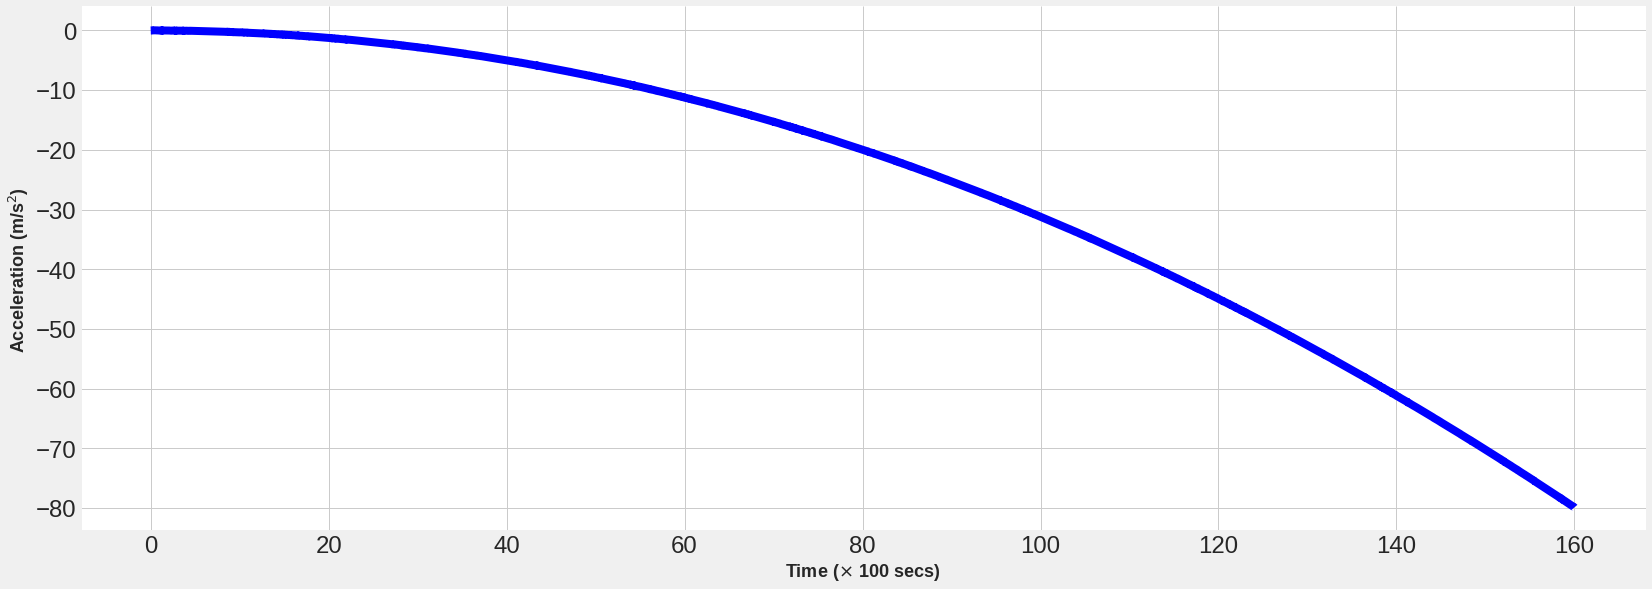

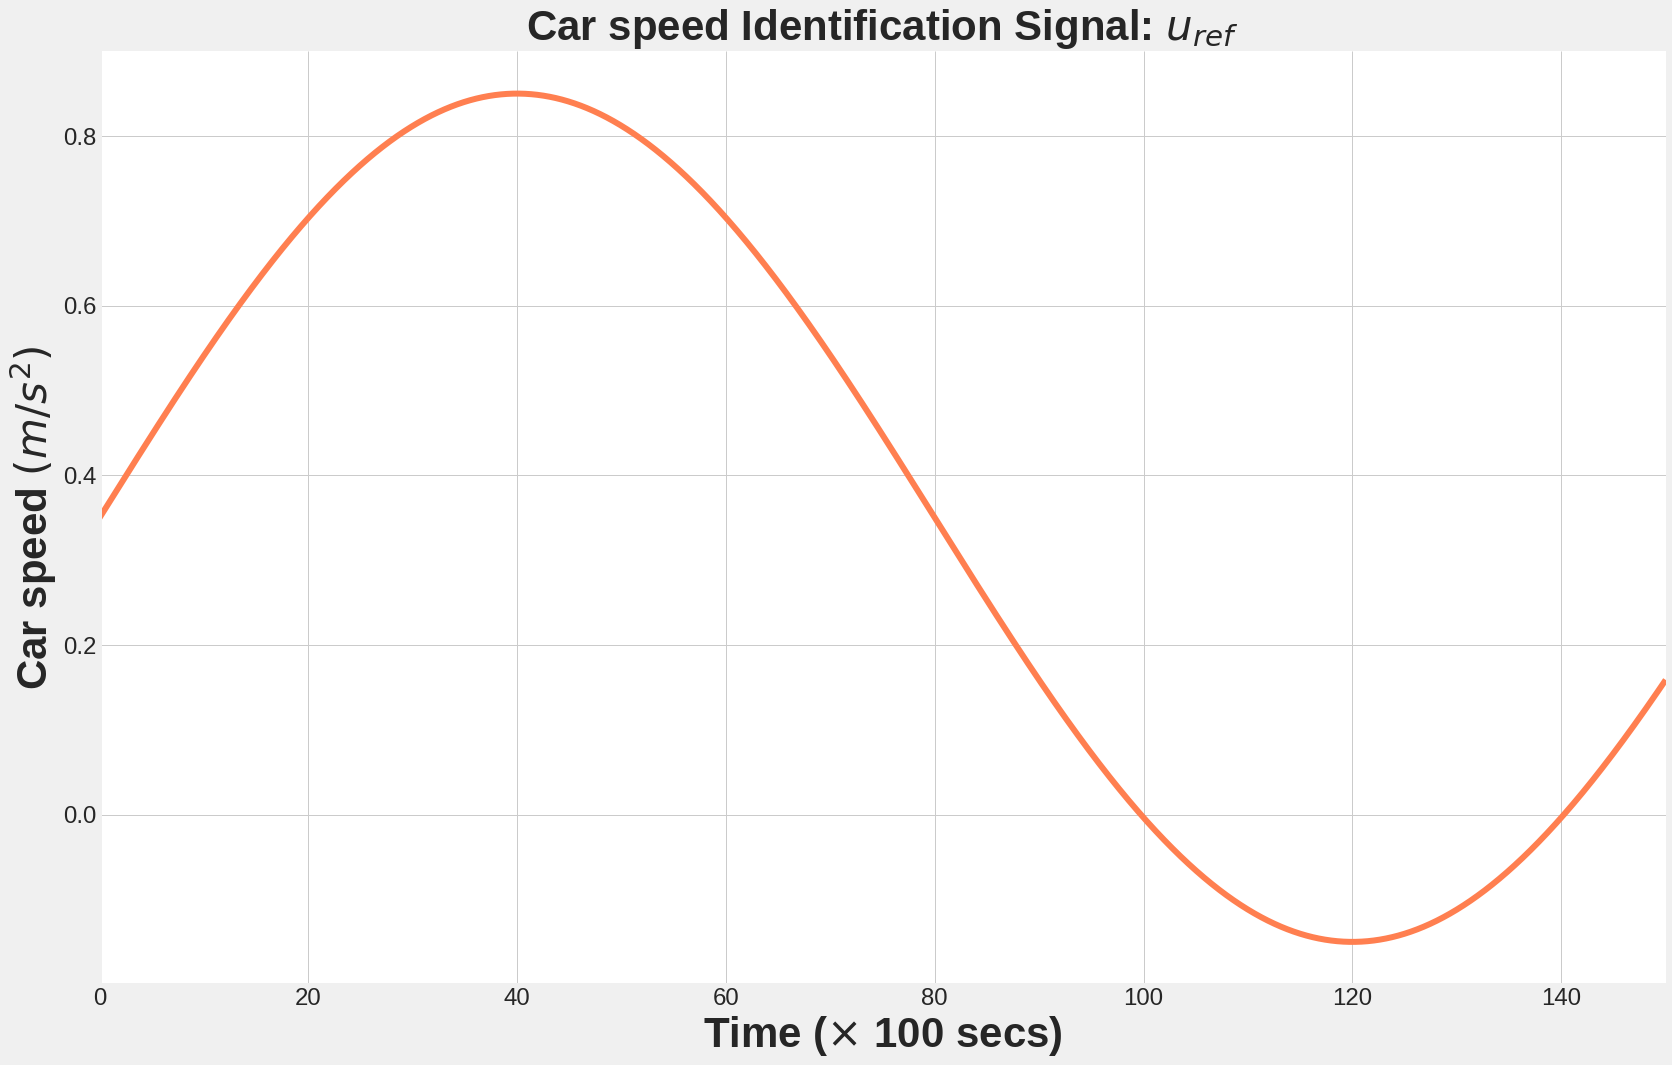

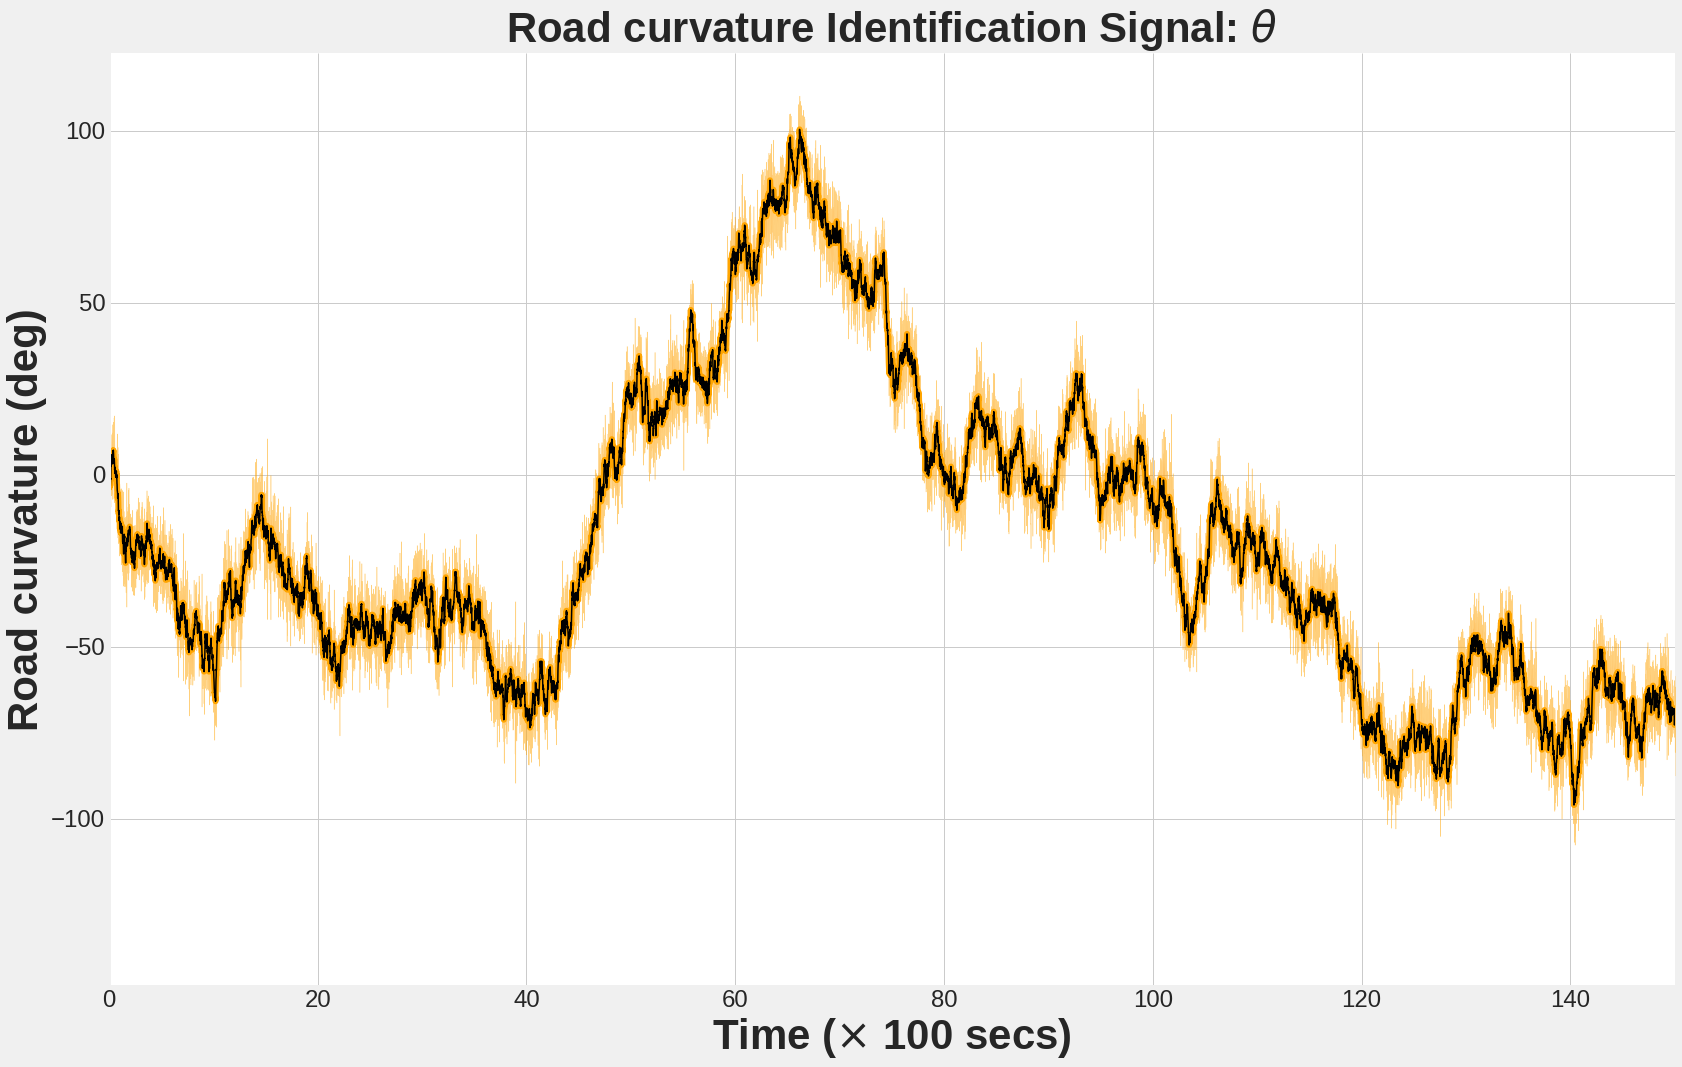

In [26]:
show = True
cruiser = CruiseControlModel(n=1, m=3, d=1)
u, x = cruiser.data_collect(ndata=16000)
u, x = u, np.expand_dims(x, 1)

from os.path import join, expanduser 
basepath = join(expanduser("~"),"Documents/Papers/Pubs23/IFAC/figures")

if show:

    T = np.linspace(0, x.size, x.size)

    fontdict = {"fontsize":18, "fontweight":"bold"}
    colors = ["orange",  "brown", "magenta", "blue"]
    legends = [rf"Car speed $(m/s^2)$", "Gear ratio", "Road curvature (deg)"]
    titles = [rf"Identification Signal: $u_{{ref}}$", rf"Identification Signal: $\alpha_n$", rf"Identification Signal: $\theta$"]

    plt.figure(figsize=(25,9))
    plt.plot(T/100, x/1000, label=rf"$x(v)$: Car acceleration $(Km/s^2)$", color="blue", linewidth=8)
    plt.xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
    plt.ylabel(rf"Acceleration (m/s$^2$)", fontdict=fontdict)
    plt.gca().xaxis.set_tick_params(labelsize=24)
    plt.gca().yaxis.set_tick_params(labelsize=24)
    plt.grid("on")
    plt.savefig(join(basepath, "ident_output.jpg"), dpi=79, facecolor=None)
    plt.show()

# u = u.T
# separate figures 
fontdict = {"fontsize":42, "fontweight":"bold"}
legends = [rf"Car speed $(m/s^2)$", "Gear ratio", "Road curvature (deg)"]
titles = [rf"Identification Signal: $u_{{ref}}$", rf"Identification Signal: $\alpha_n$", rf"Identification Signal: $\theta$"]
i = 0
idx = 0
fig, ax = plt.subplots(1, 1, figsize=(25,16))

style="fivethirtyeight"
facecolor="white"
plt.style.use(style)
plt.rcParams["axes.facecolor"] = facecolor

ax.plot(T/100, u[idx], label=rf"Car speed, $u_{idx+1}  $(m/s^2)", color="coral", linewidth=6)
ax.set_xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
ax.set_ylabel(rf"Car speed $(m/s^2)$", fontdict=fontdict)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.grid("on")
ax.set_title("Car speed " + titles[idx], fontdict=fontdict)
ax.set_xlim([0, 150])
plt.savefig(join(basepath, "ident_inputs_car_speed.jpg"), dpi=79, facecolor=None)

i += 1
idx = 2
fig, ax = plt.subplots(1, 1, figsize=(25,16))



ax.plot(T/100, u[idx], label=rf"Road curvature, $u_{idx+1}$ (deg)", color="orange", linewidth=6)
ax.set_xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
ax.set_ylabel(rf"Road curvature (deg)", fontdict=fontdict)
ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.grid("on")
ax.set_title("Road curvature "+ titles[idx], fontdict = fontdict)
# ax.set_title("Identification Inputs: Road curvature and car speed", fontdict = fontdict)
ax.set_xlim([0, 150])


errs =  np.random.normal(0.4, 6, size=u[2].shape) #u[2] + 0.04

ax.plot(T/100, u[2], label=rf"$u_{idx+1}$: {legends[idx]}", color="k", linewidth=1.5)
draw_error_band(ax, T/100, u[2], err=errs, facecolor=f"C{4}", edgecolor="none", alpha=.3)

plt.savefig(join(basepath, "ident_inputs_car_incl.jpg"), dpi=79, facecolor=None)


u = u.T

### Do a NARMAX Identification from I/O data

In [12]:

ratio = int(0.8*len(u))
x_train, y_train = u[:ratio], x[:ratio]
x_test,  y_test  = u[ratio:], x[ratio:]

xlag, ylag =[1, 1, 1], 1

degree = 3
cruise_func = CruiseControlBasis(xlag, ylag, noise_var=1e-5, degree=degree, ensemble=False)

frols_model = FROLS2(
    order_selection=False,
    n_terms=4,
    n_info_values=4,
    extended_least_squares=False,
    ylag=ylag, xlag=xlag,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=cruise_func
)

# get regression matrix from Cruise Control Model Basis Class
P_matrix = cruise_func.fit(X=x_train, y=y_train)

print("reg_matrix: ", P_matrix.shape)
    
# Estimate the Theta parameters based on calculated Reg. Matrix
frols_model.fit(X=x_train, y=y_train, reg_matrix=P_matrix)
theta = frols_model.theta 
print()

reg_matrix:  (12799, 35)



### Model Evaluation 

In [13]:
# make predictions based on test data
yhat = cruise_func.predict(x_test, y_test[:frols_model.max_lag], frols_model.pivv, frols_model.final_model , 
                            frols_model.xlag, frols_model.ylag, frols_model.max_lag, theta=theta, horizon=None)

rrse = root_relative_squared_error(y_test, yhat)
print('rrse ', rrse)

r = pd.DataFrame(
    results(
        frols_model.final_model, frols_model.theta, frols_model.err,
        frols_model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
# plot_results(y=y_test, yhat = yhat, n=10000)
ee = compute_residues_autocorrelation(y_test, yhat)

rrse  0.14457127875721665
         Regressors   Parameters             ERR
0   x2(k-1)^2y(k-1)   6.2517E-02  9.99999925E-01
1  x2(k-1)^2x1(k-1)  -8.2936E-02  2.14686362E-09
2   x2(k-1)y(k-1)^2   5.5852E-10  3.71549948E-10
3     x1(k-1)y(k-1)   2.4998E+00  3.11001566E-11


### Plot residues 

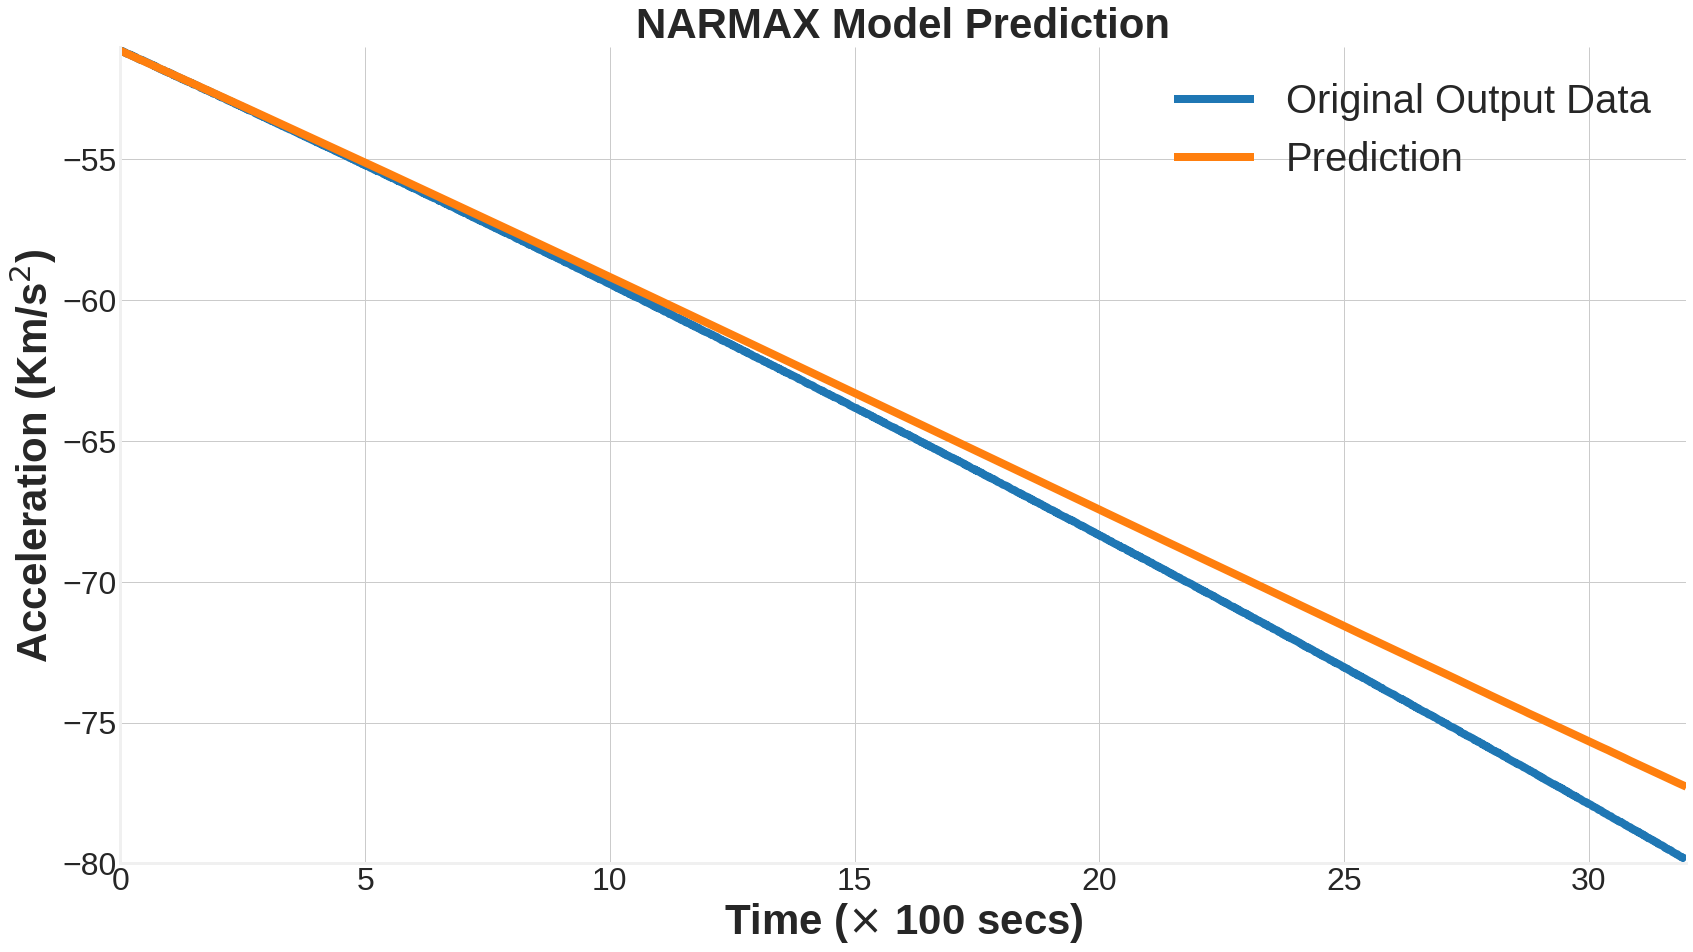

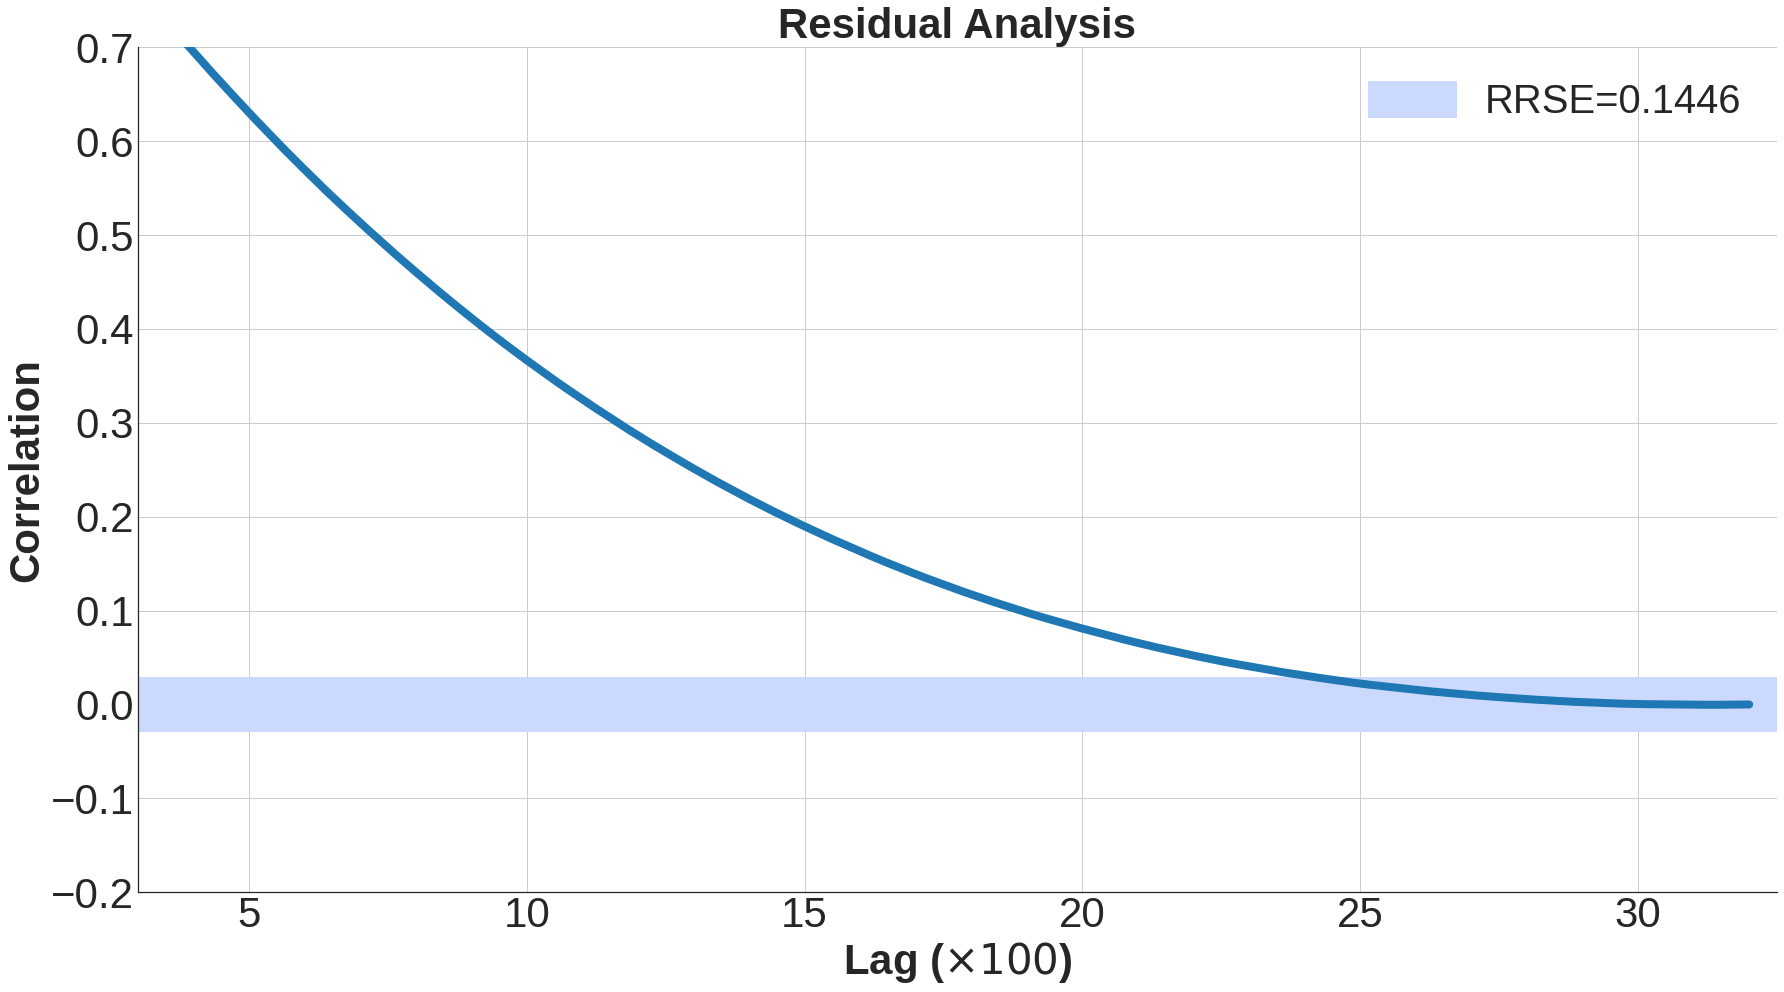

In [14]:
save = True 
plt.figure(figsize=(25,14),  facecolor="white")
ax  = plt.subplot(111)
T = np.linspace(0, y_test.size, y_test.size)
fontdict = dict(weight='bold', size=42)


ax.plot(T/100, y_test/1000, label=rf"Original Output Data", color="#1f77b4", linewidth=8)
ax.plot(T/100, yhat/1000, label=rf"Prediction", color="#ff7f0e", linewidth=8)
ax.set_title("NARMAX Model Prediction", fontdict=fontdict)
ax.set_xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
ax.set_ylabel(rf"Acceleration (Km/s$^2$)", fontdict=fontdict)
ax.set_ylim([-80, -51])
ax.set_xlim([0, 32])
ax.xaxis.set_tick_params(labelsize=32)
ax.yaxis.set_tick_params(labelsize=32)
ax.legend(loc="upper right", fontsize=40)
ax.grid("on")
if save:
    plt.savefig(join(basepath, "prediction.jpg"), dpi=79, facecolor=None)

n=100
style="seaborn-white"
facecolor="white"
title="Residual Analysis"
ylabel="Correlation"
fontdict = dict(weight='bold', size=42)

plt.style.use(style)
plt.rcParams["axes.facecolor"] = facecolor
plt.figure(figsize=(25,14),  facecolor="white")
ax  = plt.subplot(111)
T = np.linspace(0, len(ee[0]), len(ee[0]))
T /= 100
ax.plot(T, ee[0], color="#1f77b4", linewidth=8)

ax = plt.gca()
ax.axhspan(ee[1], ee[2], color="#ccd9ff", alpha=1, lw=9, label=rf"RRSE={rrse:.4f}")
ax.set_xlabel(rf"Lag ($\times 100$)", fontdict=fontdict)
ax.set_ylabel(ylabel, fontdict=fontdict)
ax.tick_params(labelsize=fontdict["size"])
ax.set_ylim([-0.2, 0.7])
ax.set_xlim([3, 32.5])
ax.grid("on")
plt.legend(loc="upper right", fontsize=40)
ax.set_title(title, fontdict=fontdict)
plt.tight_layout()
if save:
    plt.savefig(join(basepath, "residue.jpg"), dpi=79, facecolor=None)
plt.show()


### Find Equilibrium Point

+ Given certain initial conditions in $x_0$, $u_0$ and $z_0$, find all points in the state space that satisfy these equilibrium points 
via multivariate optimization using Powell method. 

In [11]:
from math import pi 
import scipy as sp 

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

xeq, ueq, weq = [20], [0.16874874, 40], [0]
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]

# solve for control w/our method here and plot I/O response

### System Response around equilibrium point (no control)


In [8]:
x0, u0, w0 = [20], [0.16874874, 40, 0], [0, 0]

A, B1, B2, C, D = linearize(x0, u0, w0)

# since we are only controlling the speed, pick B1 and B1's state components only
B1, B2, D = np.expand_dims(B1[:,0], 1), np.expand_dims(B2[:,0], 1), np.expand_dims(D[:,0], 1)

In [9]:

# pick an hinf norm bound gamma = 0.01

# with eigen placements, generate a series of stabilizing gains
possible_poles = range(-100, 0, 1)
possible_placements = [np.nan for x in range(len(possible_poles))]
Gains = [np.nan for x in range(len(possible_poles))]
Tzw = [np.nan for x in range(len(possible_poles))]
gammas = [np.nan for x in range(len(possible_poles))]

i = 0
for pole in possible_poles:
    possible_placements[i] = np.atleast_1d(np.squeeze(np.asarray(pole)))
    Gains[i] =  place_poles(A, B1, possible_placements[i], method='YT').gain_matrix

    # # for each computed gain, compute the closed loop transfer function over range of frequencies yet to be determined
    Tzw[i] = lambda w: (C - D@Gains[i])@la.pinv(1j*w - A + B1 * Gains[i])@B2

    # compute the starting value for gamma_lb
    gammas[i] = get_hinf_norm(A, B1, B2, C, D, Gains[i]).item()
    # print(pole, sla.eig(A-B1@Gains[i])[0])
    

    i += 1

INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode
INFO:Substituting symbol H from STIXNonUnicode


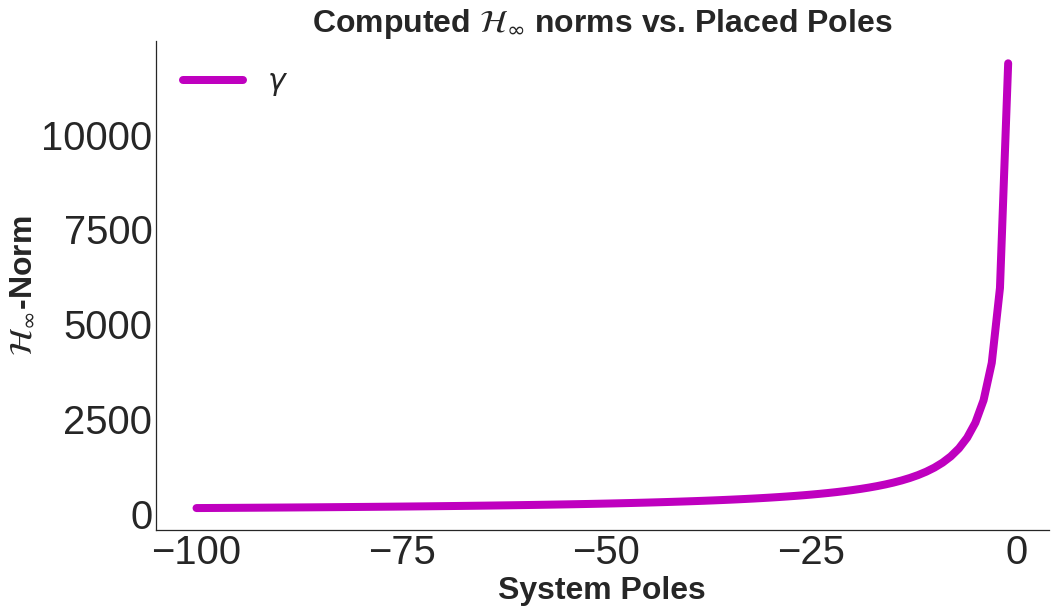

In [10]:
# Kplot = la.norm(np.array(Gains).squeeze(), ord=2, axis=1)
show = False 
fig = plt.figure(figsize=(16,9), facecolor="white")
ax  = plt.subplot(111)
ax.plot(possible_poles, np.asarray(gammas), label=rf"$\gamma$", linewidth=8, color="m")
ax.set_xlabel("System Poles", fontdict=fontdict)
ax.set_ylabel(r"$\mathcal{H}_\infty$-Norm", fontdict=fontdict)
ax.set_title(r"Computed $\mathcal{H}_\infty$ norms vs. Placed Poles", fontdict=fontdict)
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.xaxis.set_ticks([-100, -75, -50, -25, 0])
# ax.yaxis.set_ticks([700, 12000, 18000])
ax.legend(loc="upper left", fontsize=30)
if show:
    plt.savefig(join(basepath, "hinfs.jpg"), dpi=79, facecolor=None)
plt.show()

### Collect (X, U) data and form $\Phi$ and $\Psi$ -- Equations (27)-(28) in paper.

In [11]:

# find which of these stabilizing gains simulataneously satisfy the H infinity norm bound for the system before we roll the algo forward
gammas = np.array(gammas)
safe_gamma_idx = np.where(gammas>1000)
safe_gamma = gammas[np.where(gammas>1000)][0]

Gains = np.array(Gains)
K1 = Gains[safe_gamma_idx][0]
# set up system

sys = Bundle(dict(A=A, B1=B1, B2=B2, C=C, D=D, tf=150, dt=0.1, Q=C.T@C, R=D.T@D ))

T = int(sys.tf/sys.dt)     # number of simulation timesteps
T = np.linspace(0, T, T)
X0 = np.array(([40]))  # collect data 
x, u, z = sys_integrator(sys, X0, K1, T)

Phi = np.zeros((3, 3))
Psi = np.zeros((3))

for i in range(u.shape[0]-1):
    kron_term = 2*kron(x[i,:].T, u[i,:].T)
    phi = np.array([(vecv(x[i,:]).T)[0], kron_term[0], 1])
    phi = np.expand_dims(phi, 1) 
    temp = phi@phi.T*sys.dt
    # print("temp: ", temp.shape)
    Phi += temp

    # psi now 
    Psi += phi@(vecv(x[i+1,:])-vecv(x[i,:])).T

Phi /= sys.tf
Psi /= sys.tf 
PhiInv = la.inv(Phi)

# Divide up the data 
n = 1; m = 1; n1 = int(n*(n+1)/2); n2 = int(n1 + m*n);

Phi_1_bar = PhiInv[:n1]
Phi_2_bar = PhiInv[n1:n2]

print("Phi_1_bar, Phi_2_bar, Psi ", Phi_1_bar.shape, Phi_2_bar.shape, Psi.shape)

Phi_1_bar, Phi_2_bar, Psi  (1, 3) (1, 3) (3,)


### Now Solve for Robust Controller

In [12]:
def iterative_robust(A, B1, B2, C, K1, gamma, Phi1, Phi2, Psi, PIter=40, QIter=80):
    """Solve the gains in an iDG robust control framework.
    
    """

    n = A.shape[0]
    K = np.zeros((PIter,)+(K1.shape))
    L = np.random.normal(size=(QIter, B2.shape[0], A.shape[0]))
    K[0,:] = K1
    Rmat = np.eye(K1.T.shape[-1])
    P = np.random.normal(size=(PIter, QIter, n,n))


    for p in range(1, PIter):
        L[0,:] = np.random.normal(size=L[0].shape)
        for q in range(1, QIter):
            t1 = Phi1@Psi 
            t2 = smat(kron(np.eye(n), K[p-1,:].T) + kron( K[p-1,:].T, np.eye(n)) )@Phi2@Psi 
            t3 = smat(kron(np.eye(n), L[q-1, :].T@B2.T) + kron( L[q-1, :]@B2.T, np.eye(n)))

            Upsilon = t1 - t2 + t3

            Qp = C.T@C - K[p-1,:].T@Rmat@K[p-1,:]

            P[p,q] = la.pinv(Upsilon)@svec(Qp - (gamma**(-2))*L[q-1,:].T@L[q-1,:])
            L[q,:] = gamma**(-2)*B2.T@P[p,q]
        K[p, :] = la.pinv(Rmat)*B1.T@P[p, q]

    return K, L, P    

In [13]:
PIter, QIter = 20, 45 
safe_gamma = 872.43117673

# compute Popt via iDG synthesis 
KItr, LItr, PItr = iterative_robust(A, B1, B2, C, K1,  safe_gamma, Phi_1_bar, Phi_2_bar, Psi, PIter, QIter)

### Solve the Riccati Equation (almost) analytically.

In [14]:
# compute Popt via solve_care 
Rmat = np.eye(K1.T.shape[-1])
Q = C.T@C 
Popt, Kopt, Lopt = solve_gare(A, B1, B2, Q, Rmat, safe_gamma)

In [15]:
# compute P's relative error
Pnorm = np.zeros((PIter, 1))
for piter in range(PIter):
    Pnorm[piter] = la.norm(PItr[piter,-1,0,0]- Popt, ord='fro' )/la.norm(Popt, ord='fro')

# compute Gain's relative error over time 
Knorm = np.zeros((PIter,1))
for piter in range(PIter):
    Knorm[piter] = la.norm(KItr[piter,0,0]- Kopt, ord='fro' )/la.norm(Kopt, ord='fro')

# # solve for the H infinity norm error 
# Hnorm = np.zeros((PIter,1))
# for piter in range(PIter):
#     Hnorm[piter] =  get_hinf_norm(A, B1, B2, C, D, KItr[piter]).item()

TypeError: only integer scalar arrays can be converted to a scalar index

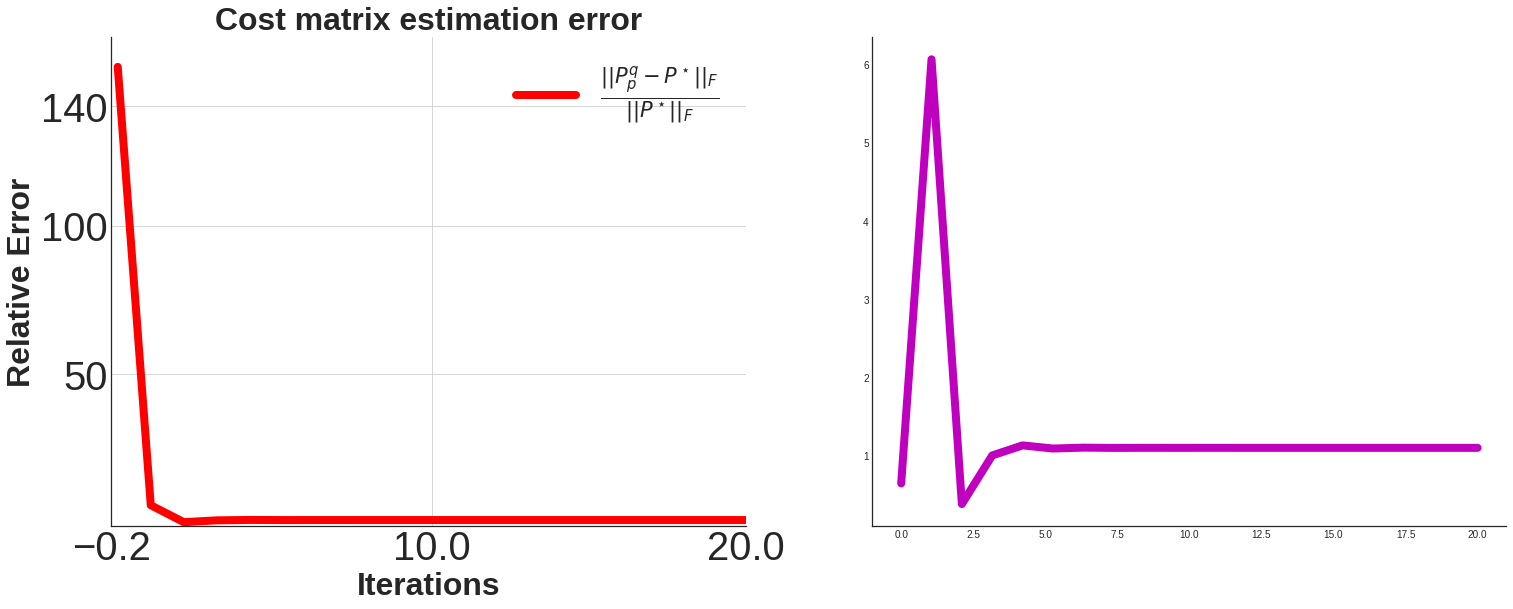

In [16]:
# show me what you got
save = False 
fig = plt.figure(figsize=(25,9), facecolor="white")
ax  = plt.subplot(121)
xlim_start = 1.04
T = np.linspace(0, PIter, PIter)

# pl.ot the cost matrix
ax.plot(T, Pnorm, label=r"$\frac{\||P_p^q - P^\star\||_F}{\||P^\star\||_F}$", linewidth=8, color="r")
ax.set_xlabel("Iterations", fontdict=fontdict)
ax.set_ylabel(r"Relative Error", fontdict=fontdict)
ax.set_title(r"Cost matrix estimation error", fontdict=fontdict)
ax.set_xlim([0,PIter])
ax.set_ylim([-1,max(Pnorm)+10])
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.xaxis.set_ticks([-0.2, 10, PIter])
ax.yaxis.set_ticks([50, 100, 140])
ax.legend(loc="upper right", fontsize=30)
ax.grid("on")


ax  = plt.subplot(122)
T = np.linspace(0, PIter, PIter)
ax.plot(T, Knorm, label=r"$\frac{\||K_p - K^\star\||_F}{\||K^\star\||_F}$", linewidth=8, color="m")

err = np.random.normal(0, 0.1, size=Knorm)
ax.fill_between(T, Knorm-err, Knorm+err,
    alpha=0.2, edgecolor='cyan', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)

ax.set_xlabel("Iterations", fontdict=fontdict)
ax.set_ylabel(r"Relative Error", fontdict=fontdict)
ax.set_title(r"Gain matrix estimation error", fontdict=fontdict)
ax.grid("on")
ax.set_xlim([1.04,PIter])
ax.xaxis.set_ticks([5, 10, 15, PIter])
ax.yaxis.set_ticks([0, 2.5, 5, 6.5])
ax.yaxis.set_ticks([])
ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40) 
# ax.yaxis.set_ticks([50, 150, 200])
ax.legend(loc="upper right", fontsize=30)
if save:
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "cost_gain_mat.eps"), dpi=79, facecolor=None)
plt.show()

In [145]:
def RK4_Integ(OdeFun, x, u, tspan=None):
    """
    # RK4 integrator for a time-invariant dynamical system under a control, u,
    and disturbance, v.

    # See https://lpsa.swarthmore.edu/NumInt/NumIntFourth.html

    This impl adopted from unstable-zeros's learning CBFs example for two airplanes

    https://github.com/unstable-zeros/learning-cbfs/blob/master/airplane_example/learning_cbfs_airplane.ipynb

    This function must be called within a loop for a total of N
    steps of integration, Obviously, the smallet the value of T, the better

    Inp.ts:
        OdeFun: Right Hand Side of Ode function to be integrated
        tspan: A list [start, end] that specifies over what time horizon to integrate the dynamics
        x: State, must be a list, initial condition
        u: Control, must be a list
        v: Disturbance, must be a list

        Author: Lekan Molu, August 09, 2021
    """
    M = 4 # RK4 steps per interval
    h = 0.2 # time step
    if np.any(tspan):
        hh = (tspan[1]-tspan[0])/10/M
    X = np.array(x)
    U = u

    for j in range(M):
        if np.any(tspan): # integrate for this much time steps
            for h in np.arange(tspan[0], tspan[1], hh):
                k1 = OdeFun(X, U)
                k2 = OdeFun(X + h/2 * k1, U)
                k3 = OdeFun(X + h/2 * k2, U)
                k4 = OdeFun(X + h * k3, U)

                X  = X+(h/6)*(k1 +2*k2 +2*k3 +k4)
        else:
            k1 = OdeFun(X, U)
            k2 = OdeFun(X + h/2 * k1, U)
            k3 = OdeFun(X + h/2 * k2, U)
            k4 = OdeFun(X + h * k3, U)

            X  = X+(h/6)*(k1 +2*k2 +2*k3 +k4)

    return X

In [16]:
n = 1
Iters = int(sys.tf/sys.dt+1)
X_LEQG = np.zeros((Iters, n))
X_H2 = np.zeros((Iters, n))
# X0 = np.array([xeq[0], 0])
U0 = [vref, gear, theta_hill]
X_LEQG[0,:] = np.array([xeq[0]])

noise_Gauss = np.random.normal(0, 1, n)
dw = np.cumsum(noise_Gauss)

for step in range(1, Iters):
    xdiff = X_LEQG[step-1,:] - xd
    X_LEQG[step,:] = X_LEQG[step-1,:] + (A@X_LEQG[step-1,:] - B1*KItr[-1]*X_LEQG[step-1,:])*sys.dt + B2*LItr[-1]*dw

NameError: name 'xd' is not defined

In [17]:

from math import pi
import control as ct

class CruiseControlModel():
    def __init__(self, n=1, m=3, d=2):
        """Parameters for the model. 
            n: state dimension (velocity of the car)
            m: control dimension (Throttle, gear ratio, road)
            d: disturbance dimension (Rolling Friction, Aero Drag and Gravity)
        """
        self.n = n
        self.m = m
        self.d = d 

    def gen_bin_seq(self, N, p_swd, nmin=1, interval=[-1.0, 1.0], tol = 0.01, nit_max = 30):
        """
            Function which generates a sequence Generalized Binary Noise (GBN).

            Params
            ------
            N: Sequence length (total number of samples)
            p_swd: desired probability of switching (no switch: 0<x<1 :always switch)
            nmin: minimum number of samples between two switches
            Range: input range
            tol: tolerance on switching probability relative error
            nit_max: maximum number of iterations

            Returns
            -------
            GBN: size(N); Switching probability, Number of times actually switched.

        """
        min_Range = min(interval)
        max_Range = max(interval)
        prob = np.random.random()
        # set first value
        if prob < 0.5:
            gbn = -1.0*np.ones(N)
        else:
            gbn = 1.0*np.ones(N)
        # init. variables
        p_sw = p_sw_b = 2.0             # actual switch probability
        nit = 0; 
        while (np.abs(p_sw - p_swd))/p_swd > tol and nit <= nit_max:
            i_fl = 0; Nsw = 0
            for i in range(N - 1):
                gbn[i + 1] = gbn[i]
                # test switch probability
                if (i - i_fl >= nmin):
                    prob = np.random.random()
                    # track last test of p_sw
                    i_fl = i
                    if (prob < p_swd):
                        # switch and then count it
                        gbn[i + 1] = -gbn[i + 1]
                        Nsw = Nsw + 1
            # check actual switch probability
            p_sw = nmin*(Nsw+1)/N; #print("p_sw", p_sw);
            # set best iteration
            if np.abs(p_sw - p_swd) < np.abs(p_sw_b - p_swd):
                p_sw_b = p_sw
                Nswb = Nsw
                gbn_b = gbn.copy()
            # increase iteration number
            nit = nit + 1; #print("nit", nit)
        # rescale GBN
        for i in range(N):
            if gbn_b[i] > 0.:
                gbn_b[i] = max_Range
            else:
                gbn_b[i] = min_Range

        return gbn_b, p_sw_b, Nswb

    def gen_white_noise(self, l, sigma):
        """Generate a white noise sequence using a zero-mean ans sigma-variance.

            Inputs
            ------
            l: (int) first dim of the noise signal
            sigma: (float or array): if array, each element of the array is used in
            computing a white noise signal.
        """
        if not isinstance(sigma, np.ndarray):
            var = np.array((sigma))
        else:
            var = sigma 
        n = var.size 
        noise = np.zeros((n, l))

        for i in range(n):
            if var[i] < np.finfo(np.float64).eps:
                import sys 
                var[i] = np.finfo(np.float64).eps 
                sys.stdout.write("\033[0;35m")
                print("Warning: Var[", i,
                    "] may be too small, its value is below machine epsilon.")
                sys.stdout.write(" ")
            noise[i,:] = np.random.normal(0., var[i]**0.5, l)
        
        return noise
        
    def motor_torque(self, omega, params={}):
        # Set up the system parameters
        Tm = params.get('Tm', 190.)             # engine torque constant
        omega_m = params.get('omega_m', 420.)   # peak engine angular speed
        beta = params.get('beta', 0.4)          # peak engine rolloff

        return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

    def dynamics(self, t, v, u, params={}):
        """Vehicle dynamics for cruise control system.

        Parameters
        ----------
        v : array
            System state: car velocity in m/s
        u : array
            System input: [throttle, gear, road_slope], where throttle is
            a float between 0 and 1, gear is an integer between 1 and 5,
            and road_slope is in rad.

        Returns
        -------
        float
            Vehicle acceleration

        """
        # assert isinstance(u, list), "u must be a list of respective input arrays."
        
        from math import copysign, sin
        sign = lambda x: copysign(1, x)         # define the sign() function
        
        # Set up the system parameters
        m = params.get('m', 1600.)              # vehicle mass, kg
        g = params.get('g', 9.8)                # gravitational constant, m/s^2
        Cr = params.get('Cr', 0.01)             # coefficient of rolling friction
        Cd = params.get('Cd', 0.32)             # drag coefficient
        rho = params.get('rho', 1.3)            # density of air, kg/m^3
        A = params.get('A', 2.4)                # car area, m^2
        alpha = params.get(
            'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

        # Define variables for vehicle state and inputs
        throttle = u[0]     # vehicle throttle
        gear     = u[1]     # vehicle gear
        theta    = u[2]     # road slope

        # Force generated by the engine
        omega = alpha[int(gear)-1] * v      # engine angular speed
        F = omega * self.motor_torque(omega, params) * throttle

        # Disturbance forces
        #
        # The disturbance force Fd has three major components: Fg, the forces due
        # to gravity; Fr, the forces due to rolling friction; and Fa, the
        # aerodynamic drag.

        # Letting the slope of the road be \theta (theta), gravity gives the
        # force Fg = m g sin \theta.
        
        Fg = m * g * np.sin(theta)

        # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
        # the coefficient of rolling friction and sgn(v) is the sign of v (±1) or
        # zero if v = 0.
        
        Fr  = m * g * Cr * np.array([sign(x) for x in v])

        # The aerodynamic drag is proportional to the square of the speed: Fa =
        # 1/2 \rho Cd A |v| v, where \rho is the density of air, Cd is the
        # shape-dependent aerodynamic drag coefficient, and A is the frontal area
        # of the car.

        Fa = 1/2 * rho * Cd * A * abs(v) * v
        
        # Final acceleration on the car
        Fd = Fg + Fr + Fa
        dv = (F - Fd) / m
        
        return dv

### Using Murray's Method

In [18]:
import control as ct
cru_model = CruiseControlModel(n=1,m=3,d=1)

vehicle = ct.NonlinearIOSystem(
    cru_model.dynamics, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

def sf_update(t, z, u, params={}):
    y, r = u[1], u[2]
    return y - r

def sf_output(t, z, u, params={}):
    K = params.get('K',  Kopt)
    L = params.get('L',  Lopt)
    kf = params.get('kf', 0)
    yd = params.get('yd', 0)
    xd = params.get('xd', 0)

    # print("K: ", K, "L: ", L)
    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return (ud-K* (x-xd)) + (ud+ L*(x-xd)) + kf * (r-yd)

# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, sf_output, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))


cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])   

# Define the time and input vectors
T = np.linspace(0, 25, 501)   

vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Compute the steady state velocity and throttle setting
xd = xeq[0]
ud = ueq[0]
yd = vref[-1]

# Response of the system with no integral feedback term
# plt.figure(figsize)
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
K = Kopt.item()
kf = (-1 / ((C-D*K) * np.linalg.inv(A - B1 * K) * B2)).item(0)

In [19]:

# Define a function for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, label=None, t_hill=None, vref=20, antiwindup=False,
                linetype='b-', subplots=None, legend=None):
    if subplots is None:
        subplots = [None, None]
    # Figure out the plot bounds and indices
    v_min = vref - 1.2; v_max = vref + 0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1

    # Create arrays for return values
    subplot_axes = list(subplots)

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--', label='t hill')
    plt.axis([0, t[-1], v_min, v_max])
    # plt.xlabel('Time $t$ [s]', fontdict=fontdict)
    plt.ylabel('Velocity $v$ [m/s]', fontdict=fontdict)

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype, label=label)
    # Applied input profile
    if antiwindup:
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype, label='Applied')
    if t_hill:
        plt.axvline(t_hill, color='k', linestyle='--')
    if legend:
        plt.legend(frameon=False)
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]', fontdict=fontdict)
    plt.ylabel('Throttle $u$', fontdict=fontdict)

    return subplot_axes

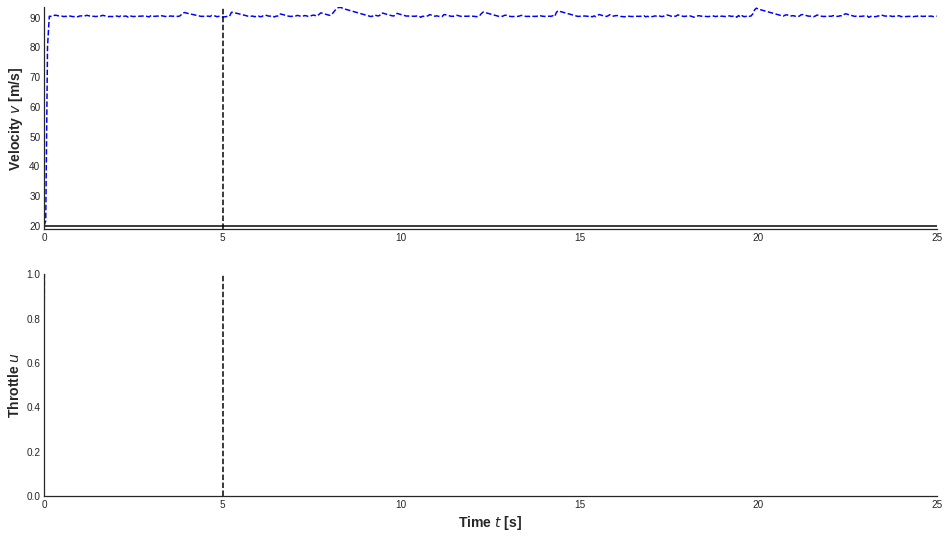

In [20]:

fontdict = {"fontsize":14, "fontweight":"bold"}
plt.figure(figsize=(16,9))
t, y_sfb = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [xeq[0], 0],
    params={'K':K, 'L': 0, 'kf':0, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y_sfb, t_hill=5, linetype='b--')

# Response of the system with state feedback + integral action
# t, y_sfb_int = ct.input_output_response(
#     cruise_sf, T, [vref, gear, theta_hill], [xeq[0], 0],
#     params={'K':K, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
# cruise_plot(cruise_sf, t, y_sfb_int, t_hill=5, linetype='b-', subplots=subplots)

In [167]:
n = 1
Iters = int(sys.tf/sys.dt+1)
X_leqg = np.zeros((Iters, n))
X_Hinf = np.zeros((Iters, n))

X_leqg[0,:] = np.array([xeq[0]])
X_Hinf[0,:] = np.array([xeq[0]])

noise_Gauss = np.random.normal(0, 1, n)
dw = np.cumsum(noise_Gauss)


M, h = 100, 0.2 # time step
sys.dt = 0.001
for step in range(1, Iters):
    # dw = np.cumsum(np.random.normal(0, 1, n))
    dw = np.random.normal(0, 1, n)
    dt_root = np.sqrt(sys.dt)
    # RK45 Integration
    for j in range(M):
        k1 = (A@X_leqg[step-1,:] - B1@Kopt@X_leqg[step-1,:])*sys.dt + B2*dw*dt_root
        k2 = (A@X_leqg[step-1,:]+ h/2 * k1 - B1@Kopt@X_leqg[step-1,:]+ h/2 * k1)*sys.dt + B2*dw*dt_root
        k3 = (A@X_leqg[step-1,:]+ h/2 * k2 - B1@Kopt@X_leqg[step-1,:]+ h/2 * k2)*sys.dt + B2*dw*dt_root
        k4 = (A@X_leqg[step-1,:]+ h * k3 - B1@Kopt@X_leqg[step-1,:]+ h * k3)*sys.dt + B2*dw*dt_root

        X_leqg[step,:]  = X_leqg[step-1,:]+(h/6)*(k1 +2*k2 +2*k3 +k4)


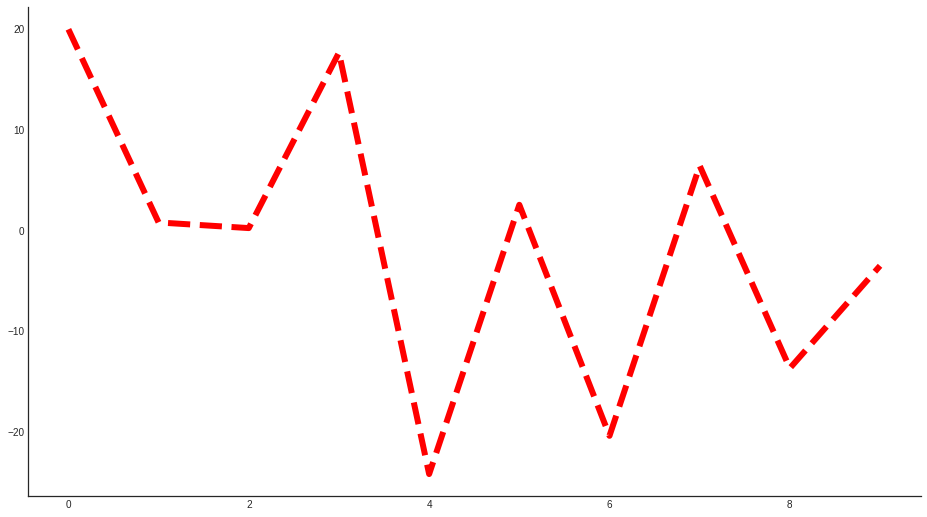

In [169]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)

ax.plot(X_leqg[:10], linestyle='--', color='r', linewidth=6, label="Car Speed")

In [160]:
np.sqrt(0.1)

0.31622776601683794